   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/raffihassanbasha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raffihassanbasha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Train Data:
                                id corpus  \
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible   
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C  bible   
2  3S1WOPCJFGTJU2SGNAN2Y213N6WJE3  bible   
3  3BFNCI9LYKQN09BHXHH9CLSX5KP738  bible   
4  3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2  bible   

                                            sentence     token  complexity  
0  Behold, there came up out of the river seven c...     river    0.000000  
1  I am a fellow bondservant with you and with yo...  brothers    0.000000  
2  The man, the lord of the land, said to us, 'By...  brothers    0.050000  
3  Shimei had sixteen sons and six daughters; but...  brothers    0.150000  
4  He has put my brothers far from me.\tbrothers\...      sons    0.055556  
Test Data:
                                id corpus  \
0  39TX062QX1OHFOH8FUL76K5L7D3X3S  bible   
1  3CIS7GGG65JS8I3AZ9RG54AE4MUUEA  bible   
2  379OL9DBSSESUVWY1Z8JGBFG9BTY92  bible   
3  3DFYDSXB2W00JYP2DA272KN69UQUJV  bible   
4  31YWE12TE0CZG7IVH6OXJ1H1C

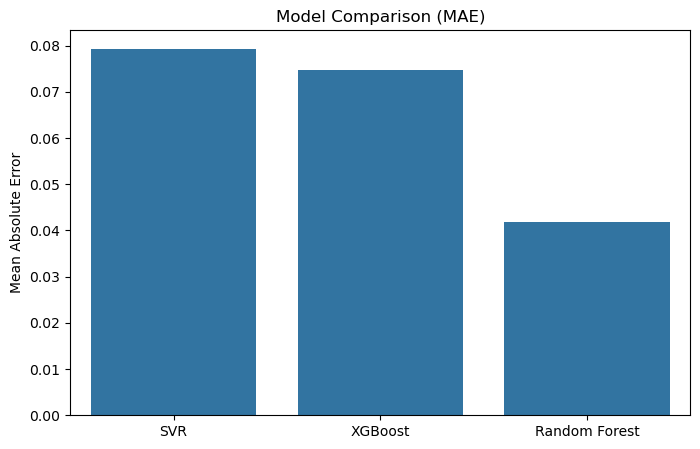

In [3]:
# Import necessary libraries
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import nltk
from nltk.tokenize import word_tokenize

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load dataset
train_df = pd.read_csv("/Users/raffihassanbasha/Downloads/CompLex-master/train/lcp_single_train.tsv", sep="\t")
test_df = pd.read_csv("/Users/raffihassanbasha/Downloads/CompLex-master/test/lcp_single_test.tsv", sep="\t")

# Check dataset structure
print("Train Data:\n", train_df.head())
print("Test Data:\n", test_df.head())

# Ensure correct column names
print("Train columns:", train_df.columns)
print("Test columns:", test_df.columns)

# Identify the correct target word column
target_col = 'target' if 'target' in train_df.columns else 'token'

# Convert target words to strings and handle missing values
train_df[target_col] = train_df[target_col].astype(str).fillna("")
test_df[target_col] = test_df[target_col].astype(str).fillna("")

# Feature Engineering: Word Length
train_df['word_length'] = train_df[target_col].apply(len)
test_df['word_length'] = test_df[target_col].apply(len)

# TF-IDF Vectorization on Sentences
vectorizer = TfidfVectorizer(stop_words="english", max_features=500)
X_tfidf_train = vectorizer.fit_transform(train_df['sentence']).toarray()
X_tfidf_test = vectorizer.transform(test_df['sentence']).toarray()

# Convert TF-IDF to DataFrame
X_train_tfidf_df = pd.DataFrame(X_tfidf_train, columns=vectorizer.get_feature_names_out())
X_test_tfidf_df = pd.DataFrame(X_tfidf_test, columns=vectorizer.get_feature_names_out())

# Combine Features
X_train = pd.concat([X_train_tfidf_df, train_df[['word_length']]], axis=1)
X_test = pd.concat([X_test_tfidf_df, test_df[['word_length']]], axis=1)

# Target variable (complexity score) - Only available in train_df
y_train = train_df['complexity']

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVR Model
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)

# Train XGBoost Model
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Store predictions in test_df
test_df['SVR_Pred'] = y_pred_svr
test_df['XGB_Pred'] = y_pred_xgb
test_df['RF_Pred'] = y_pred_rf

# Save predictions to CSV
test_df[['token', 'SVR_Pred', 'XGB_Pred', 'RF_Pred']].to_csv("test_predictions.csv", index=False)

# Model Performance (Only for Training Set)
y_pred_train_svr = svr_model.predict(X_train_scaled)
y_pred_train_xgb = xgb_model.predict(X_train_scaled)
y_pred_train_rf = rf_model.predict(X_train_scaled)

print("SVR MAE:", mean_absolute_error(y_train, y_pred_train_svr))
print("XGBoost MAE:", mean_absolute_error(y_train, y_pred_train_xgb))
print("Random Forest MAE:", mean_absolute_error(y_train, y_pred_train_rf))

# Visualization: Model Comparison
models = ['SVR', 'XGBoost', 'Random Forest']
mae_scores = [mean_absolute_error(y_train, y_pred_train_svr), 
              mean_absolute_error(y_train, y_pred_train_xgb), 
              mean_absolute_error(y_train, y_pred_train_rf)]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=mae_scores)
plt.title("Model Comparison (MAE)")
plt.ylabel("Mean Absolute Error")
plt.show()


In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to evaluate models
def evaluate_model(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.5f}")
    print(f"RMSE: {rmse:.5f}")
    print(f"R² Score: {r2:.5f}")
    print("-" * 40)

# Evaluate models on training data
evaluate_model("SVR", y_train, svr_model.predict(X_train_scaled))
evaluate_model("XGBoost", y_train, xgb_model.predict(X_train_scaled))
evaluate_model("Random Forest", y_train, rf_model.predict(X_train_scaled))


SVR Performance:
MAE: 0.07934
RMSE: 0.09414
R² Score: 0.49964
----------------------------------------
XGBoost Performance:
MAE: 0.07464
RMSE: 0.09665
R² Score: 0.47257
----------------------------------------
Random Forest Performance:
MAE: 0.04182
RMSE: 0.05839
R² Score: 0.80751
----------------------------------------


In [7]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for SVR
svr_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'epsilon': [0.01, 0.1, 0.2]}
svr_grid = GridSearchCV(SVR(), svr_params, scoring='neg_mean_absolute_error', cv=3, verbose=1)
svr_grid.fit(X_train_scaled, y_train)
best_svr = svr_grid.best_estimator_
print("Best SVR Parameters:", svr_grid.best_params_)

# Hyperparameter tuning for XGBoost
xgb_params = {'n_estimators': [100, 300], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]}
xgb_grid = GridSearchCV(XGBRegressor(objective="reg:squarederror"), xgb_params, scoring='neg_mean_absolute_error', cv=3, verbose=1)
xgb_grid.fit(X_train_scaled, y_train)
best_xgb = xgb_grid.best_estimator_
print("Best XGBoost Parameters:", xgb_grid.best_params_)

# Hyperparameter tuning for Random Forest
rf_params = {'n_estimators': [100, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, scoring='neg_mean_absolute_error', cv=3, verbose=1)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best SVR Parameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale'}
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}


In [9]:
# Evaluate tuned models on training data
evaluate_model("Tuned SVR", y_train, best_svr.predict(X_train_scaled))
evaluate_model("Tuned XGBoost", y_train, best_xgb.predict(X_train_scaled))
evaluate_model("Tuned Random Forest", y_train, best_rf.predict(X_train_scaled))


Tuned SVR Performance:
MAE: 0.08859
RMSE: 0.11121
R² Score: 0.30164
----------------------------------------
Tuned XGBoost Performance:
MAE: 0.09562
RMSE: 0.12266
R² Score: 0.15048
----------------------------------------
Tuned Random Forest Performance:
MAE: 0.09078
RMSE: 0.11605
R² Score: 0.23964
----------------------------------------


In [13]:
# Predict on test set with best models
test_df['SVR_Pred'] = best_svr.predict(X_test_scaled)
test_df['XGB_Pred'] = best_xgb.predict(X_test_scaled)
test_df['RF_Pred'] = best_rf.predict(X_test_scaled)

# Save final predictions
test_df[['token', 'SVR_Pred', 'XGB_Pred', 'RF_Pred']].to_csv("final_test_predictions.csv", index=False)


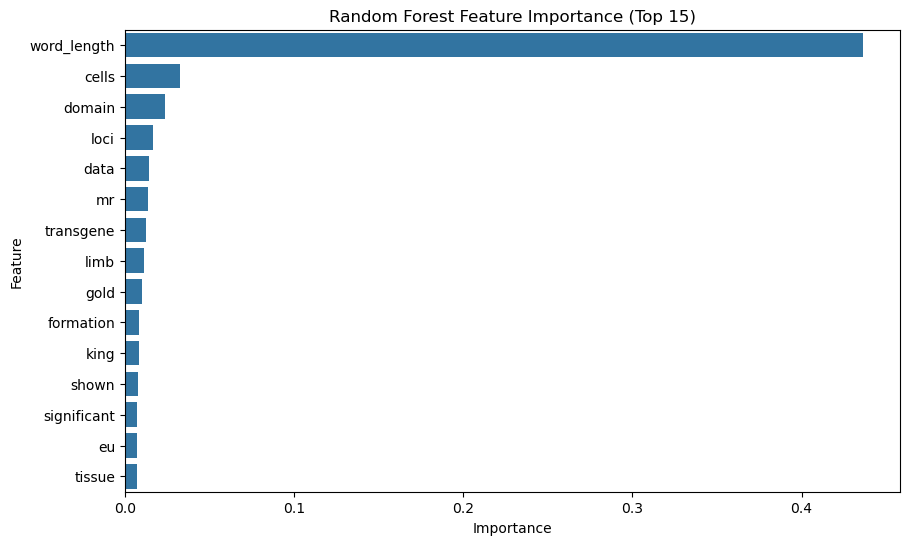

In [15]:
importances_rf = best_rf.feature_importances_
feature_names = X_train.columns

# Convert to DataFrame
feature_importance_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importances_rf})
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance_rf['Importance'][:15], y=feature_importance_rf['Feature'][:15])
plt.title("Random Forest Feature Importance (Top 15)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


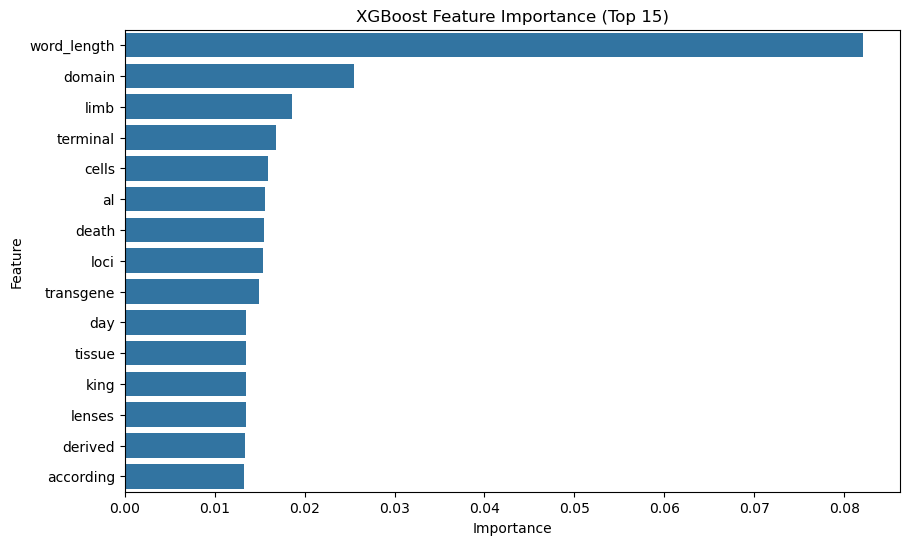

In [17]:
importances_xgb = best_xgb.feature_importances_

# Convert to DataFrame
feature_importance_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_xgb})
feature_importance_xgb = feature_importance_xgb.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance_xgb['Importance'][:15], y=feature_importance_xgb['Feature'][:15])
plt.title("XGBoost Feature Importance (Top 15)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [19]:
!pip install syllapy nltk wordfreq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 8.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 20.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.3
    Uninstalling msgpack-1.0.3:
      Successfully uninstalled msgpack-1.0.3
